# PaperBLAST Data Explorer

Characterize the `kescience_paperblast` collection on BERDL:
- Table sizes and overall scale
- Temporal coverage (how up-to-date?)
- Taxonomic coverage (top organisms per domain of life)
- Literature coverage (papers per gene distribution)
- Curated vs text-mined data
- Cross-database linkages
- Structural data (PDB sites, ligands)
- Limitations and gaps

In [1]:
from berdl_notebook_utils.setup_spark_session import get_spark_session
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

spark = get_spark_session()
DB = 'kescience_paperblast'
DATA_OUT = Path('../data')
FIG_OUT = Path('../figures')
DATA_OUT.mkdir(exist_ok=True)
FIG_OUT.mkdir(exist_ok=True)

## 1. Table Inventory and Scale

In [2]:
tables = [r.tableName for r in spark.sql(f'SHOW TABLES IN {DB}').collect()]

inventory = []
for t in tables:
    count = spark.sql(f'SELECT COUNT(*) as cnt FROM {DB}.{t}').collect()[0].cnt
    ncols = len(spark.sql(f'DESCRIBE {DB}.{t}').collect())
    inventory.append({'table': t, 'rows': count, 'columns': ncols})

inv_df = pd.DataFrame(inventory).sort_values('rows', ascending=False)
inv_df['rows_fmt'] = inv_df['rows'].apply(lambda x: f'{x:,}')
print('PaperBLAST Table Inventory')
print('=' * 50)
print(inv_df[['table', 'rows_fmt', 'columns']].to_string(index=False))
print(f'\nTotal rows across all tables: {inv_df["rows"].sum():,}')

PaperBLAST Table Inventory
         table  rows_fmt  columns
     genepaper 3,195,890       10
          site 2,089,192       12
       snippet 1,951,949        5
       generif 1,358,798        4
          gene 1,135,366        4
          uniq   815,571        3
  curatedpaper   599,587        3
seqtoduplicate   284,104        2
   paperaccess   274,899        3
   curatedgene   255,096        8
    seqhassite   146,195        5
      hassites   146,190        6
  pdbclustinfo    67,528        3
     pdbligand    48,991        2

Total rows across all tables: 12,369,356


## 2. Temporal Coverage — How Up-to-Date?

In [3]:
# Publication year distribution from genepaper
year_dist = spark.sql(f"""
    SELECT CAST(year AS INT) as pub_year, COUNT(*) as n_records, COUNT(DISTINCT pmId) as n_papers
    FROM {DB}.genepaper
    WHERE year IS NOT NULL AND CAST(year AS INT) > 1950 AND CAST(year AS INT) <= 2026
    GROUP BY CAST(year AS INT)
    ORDER BY pub_year
""").toPandas()

print(f'Year range: {year_dist["pub_year"].min()} – {year_dist["pub_year"].max()}')
print(f'Total gene-paper records with valid year: {year_dist["n_records"].sum():,}')
print(f'Total unique papers: {year_dist["n_papers"].sum():,}')
print()

# Most recent years
print('Most recent 10 years:')
print(year_dist.tail(10).to_string(index=False))
print()

# What fraction of data is from last 5 years?
recent = year_dist[year_dist['pub_year'] >= 2020]['n_records'].sum()
total = year_dist['n_records'].sum()
print(f'Records from 2020+: {recent:,} ({100*recent/total:.1f}%)')

last_year = year_dist[year_dist['pub_year'] >= 2025]['n_records'].sum()
print(f'Records from 2025+: {last_year:,} ({100*last_year/total:.1f}%)')

Year range: 1951 – 2026
Total gene-paper records with valid year: 3,171,028
Total unique papers: 1,090,006

Most recent 10 years:
 pub_year  n_records  n_papers
     2017     160031     53716
     2018     151183     49152
     2019     153412     49059
     2020     179868     53641
     2021     187509     54817
     2022     170833     42644
     2023     162245     41052
     2024     142318     33943
     2025     125438     22271
     2026       1425       466

Records from 2020+: 969,636 (30.6%)
Records from 2025+: 126,863 (4.0%)


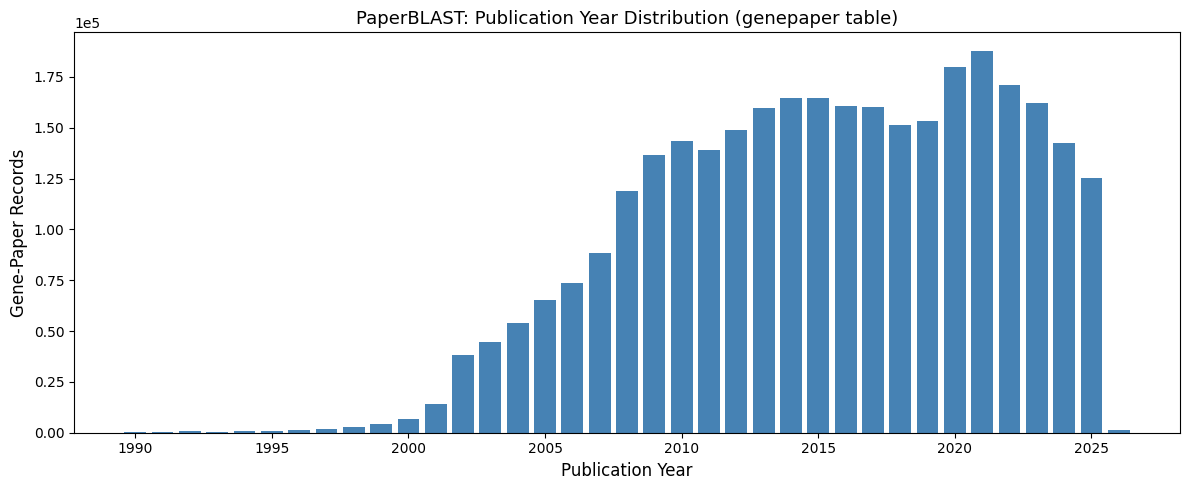

In [4]:
# Figure: Publication year distribution
fig, ax = plt.subplots(figsize=(12, 5))
recent_years = year_dist[year_dist['pub_year'] >= 1990]
ax.bar(recent_years['pub_year'], recent_years['n_records'], color='steelblue', edgecolor='none')
ax.set_xlabel('Publication Year', fontsize=12)
ax.set_ylabel('Gene-Paper Records', fontsize=12)
ax.set_title('PaperBLAST: Publication Year Distribution (genepaper table)', fontsize=13)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.tight_layout()
fig.savefig(FIG_OUT / 'year_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Taxonomic Coverage — Top Organisms by Domain

In [5]:
# Top organisms by gene count
org_counts = spark.sql(f"""
    SELECT organism, COUNT(*) as n_genes
    FROM {DB}.gene
    WHERE organism IS NOT NULL AND organism != ''
    GROUP BY organism
    ORDER BY n_genes DESC
""").toPandas()

print(f'Total organisms: {len(org_counts):,}')
print(f'Total genes: {org_counts["n_genes"].sum():,}')
print()
print('Top 30 organisms by gene count:')
print(org_counts.head(30).to_string(index=False))

Total organisms: 27,718
Total genes: 1,135,366

Top 30 organisms by gene count:
                                                                                                         organism  n_genes
                                                                                                     Homo sapiens    49075
                                                                                             Arabidopsis thaliana    47388
                                                                                                     Mus musculus    30945
                                                                                                Rattus norvegicus    15679
                                                                                          Drosophila melanogaster    11867
                                                                                      Pseudomonas aeruginosa PAO1    10266
                                                           

In [6]:
# Classify organisms by domain (heuristic based on name)
def classify_domain(org):
    org_lower = str(org).lower()
    # Eukaryotes
    euk_keywords = ['homo sapiens', 'mus musculus', 'rattus', 'drosophila', 'caenorhabditis',
                    'saccharomyces', 'arabidopsis', 'danio rerio', 'xenopus', 'gallus',
                    'bos taurus', 'sus scrofa', 'oryctolagus', 'macaca', 'pan troglodytes',
                    'schizosaccharomyces', 'neurospora', 'aspergillus', 'candida',
                    'plasmodium', 'trypanosoma', 'leishmania', 'dictyostelium',
                    'zea mays', 'oryza sativa', 'nicotiana', 'solanum', 'pichia',
                    'canis', 'felis', 'equus', 'ovis']
    if any(k in org_lower for k in euk_keywords):
        return 'Eukarya'
    # Archaea
    arch_keywords = ['methan', 'sulfolobus', 'halobacterium', 'haloferax', 'pyrococcus',
                     'thermococcus', 'archaeoglobus', 'nanoarchaeum', 'haloquadratum',
                     'nitrosopumilus', 'thaumarchae']
    if any(k in org_lower for k in arch_keywords):
        return 'Archaea'
    # Viruses
    virus_keywords = ['virus', 'phage', 'viridae', 'bacteriophage', 'sars-cov', 'hiv',
                      'influenza', 'herpes', 'hepatitis', 'adenovir', 'retrovir',
                      'poxvir', 'papillomavir']
    if any(k in org_lower for k in virus_keywords):
        return 'Virus'
    # Bacteria (default for most microbial names)
    bact_keywords = ['escherichia', 'salmonella', 'bacillus', 'staphylococcus',
                     'streptococcus', 'pseudomonas', 'mycobacterium', 'clostridium',
                     'vibrio', 'helicobacter', 'neisseria', 'bordetella', 'legionella',
                     'campylobacter', 'listeria', 'corynebacterium', 'rhodobacter',
                     'caulobacter', 'agrobacterium', 'sinorhizobium', 'bradyrhizobium',
                     'xanthomonas', 'ralstonia', 'burkholderia', 'acinetobacter',
                     'klebsiella', 'enterococcus', 'lactobacillus', 'bifidobacterium',
                     'synechocystis', 'synechococcus', 'nostoc', 'anabaena',
                     'desulfovibrio', 'geobacter', 'shewanella', 'rickettsia',
                     'chlamydia', 'borrelia', 'treponema', 'mycoplasma', 'spiroplasma']
    if any(k in org_lower for k in bact_keywords):
        return 'Bacteria'
    return 'Unknown'

org_counts['domain'] = org_counts['organism'].apply(classify_domain)

print('Domain distribution:')
domain_summary = org_counts.groupby('domain').agg(
    n_organisms=('organism', 'count'),
    n_genes=('n_genes', 'sum')
).sort_values('n_genes', ascending=False)
domain_summary['pct_genes'] = 100 * domain_summary['n_genes'] / domain_summary['n_genes'].sum()
print(domain_summary.to_string())
print()

# Top organisms per domain
for domain in ['Bacteria', 'Eukarya', 'Archaea', 'Virus']:
    sub = org_counts[org_counts['domain'] == domain].head(10)
    if len(sub) > 0:
        print(f'\nTop 10 {domain}:')
        print(sub[['organism', 'n_genes']].to_string(index=False))

Domain distribution:
          n_organisms  n_genes  pct_genes
domain                                   
Bacteria         5997   397544  35.014612
Unknown         14798   397511  35.011705
Eukarya           822   290537  25.589722
Virus            5730    27199   2.395615
Archaea           371    22575   1.988346




Top 10 Bacteria:
                                                                                                         organism  n_genes
                                                                                      Pseudomonas aeruginosa PAO1    10266
                                                                                 Mycobacterium tuberculosis H37Rv     6430
                                                                        Escherichia coli str. K-12 substr. MG1655     6249
                                                                                        Pseudomonas putida KT2440     5338
Pseudomonas aeruginosa (strain ATCC 15692 / DSM 22644 / CIP 104116 / JCM 14847 / LMG 12228 / 1C / PRS 101 / PAO1)     5238
                                                                       Bacillus subtilis subsp. subtilis str. 168     5206
                                                                                          Escherichia coli CFT073     510

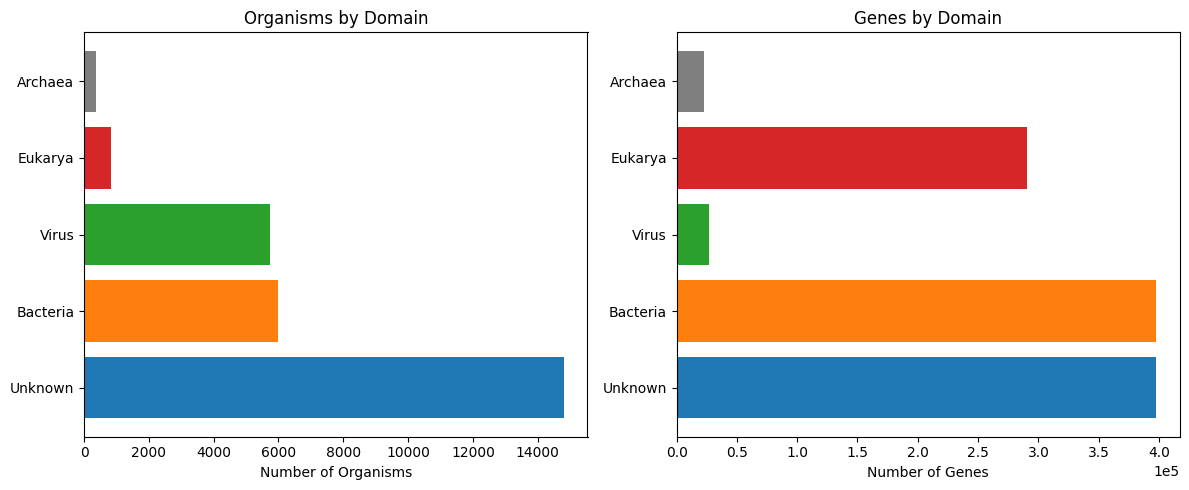

In [7]:
# Figure: Domain distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# By organisms
ax = axes[0]
ds = domain_summary.sort_values('n_organisms', ascending=False)
ax.barh(ds.index, ds['n_organisms'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#7f7f7f'])
ax.set_xlabel('Number of Organisms')
ax.set_title('Organisms by Domain')

# By genes
ax = axes[1]
ax.barh(ds.index, ds['n_genes'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#7f7f7f'])
ax.set_xlabel('Number of Genes')
ax.set_title('Genes by Domain')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.tight_layout()
fig.savefig(FIG_OUT / 'domain_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Literature Coverage — Papers per Gene

In [8]:
# Distribution of papers per gene
papers_per_gene = spark.sql(f"""
    SELECT geneId, COUNT(DISTINCT pmId) as n_papers
    FROM {DB}.genepaper
    WHERE pmId IS NOT NULL
    GROUP BY geneId
""").toPandas()

print(f'Genes with at least 1 paper: {len(papers_per_gene):,}')
print(f'Total genes in gene table: {org_counts["n_genes"].sum():,}')
print()
print('Papers per gene distribution:')
print(papers_per_gene['n_papers'].describe().to_string())
print()

# Histogram buckets
bins = [1, 2, 3, 5, 10, 20, 50, 100, 500, 10000]
for i in range(len(bins)-1):
    count = ((papers_per_gene['n_papers'] >= bins[i]) & (papers_per_gene['n_papers'] < bins[i+1])).sum()
    print(f'  {bins[i]:>4}–{bins[i+1]-1:<4} papers: {count:>8,} genes ({100*count/len(papers_per_gene):.1f}%)')
count = (papers_per_gene['n_papers'] >= bins[-1]).sum()
print(f'  {bins[-1]:>4}+     papers: {count:>8,} genes ({100*count/len(papers_per_gene):.1f}%)')
print()

# Most-cited genes
top_genes = papers_per_gene.nlargest(20, 'n_papers')
# Get descriptions
top_ids = "','".join(top_genes['geneId'].tolist())
top_desc = spark.sql(f"""
    SELECT geneId, organism, desc
    FROM {DB}.gene
    WHERE geneId IN ('{top_ids}')
""").toPandas()
top_merged = top_genes.merge(top_desc, on='geneId', how='left')
print('Top 20 most-referenced genes:')
print(top_merged.to_string(index=False, max_colwidth=50))

Genes with at least 1 paper: 840,982
Total genes in gene table: 1,135,366

Papers per gene distribution:
count    840982.000000
mean          3.749978
std          32.137569
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        9988.000000

     1–1    papers:  551,396 genes (65.6%)
     2–2    papers:  116,284 genes (13.8%)
     3–4    papers:   75,626 genes (9.0%)
     5–9    papers:   52,976 genes (6.3%)
    10–19   papers:   25,646 genes (3.0%)
    20–49   papers:   13,183 genes (1.6%)
    50–99   papers:    3,097 genes (0.4%)
   100–499  papers:    2,449 genes (0.3%)
   500–9999 papers:      325 genes (0.0%)
  10000+     papers:        0 genes (0.0%)



Top 20 most-referenced genes:
        geneId  n_papers     organism                                               desc
NP_001119584.1      9988 Homo sapiens               cellular tumor antigen p53 isoform a
   NP_000585.2      6002 Homo sapiens                              tumor necrosis factor
   NP_005219.2      5895 Homo sapiens epidermal growth factor receptor isoform a prec...
NP_001020537.2      4993 Homo sapiens vascular endothelial growth factor A, long form...
NP_001289617.1      4958 Homo sapiens               apolipoprotein E isoform a precursor
   NP_000651.3      4760 Homo sapiens transforming growth factor beta-1 proprotein pr...
   NP_005948.3      3816 Homo sapiens methylenetetrahydrofolate reductase (NADPH) iso...
   NP_001521.1      3531 Homo sapiens         hypoxia-inducible factor 1-alpha isoform 1
   NP_000563.1      3322 Homo sapiens                 interleukin-10 isoform 1 precursor
XP_016880462.1      3293 Homo sapiens signal transducer and activator of transcr

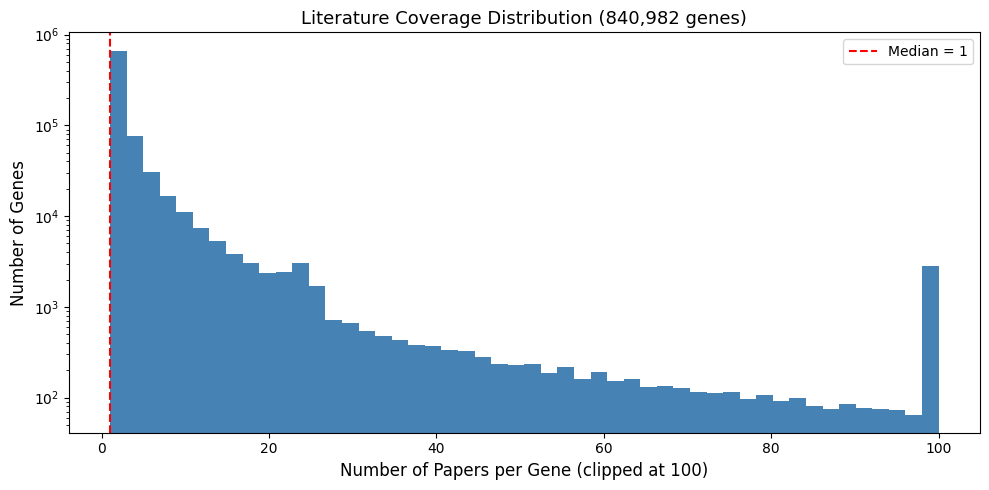

In [9]:
# Figure: Papers per gene histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(papers_per_gene['n_papers'].clip(upper=100), bins=50, color='steelblue', edgecolor='none')
ax.set_xlabel('Number of Papers per Gene (clipped at 100)', fontsize=12)
ax.set_ylabel('Number of Genes', fontsize=12)
ax.set_title(f'Literature Coverage Distribution ({len(papers_per_gene):,} genes)', fontsize=13)
ax.set_yscale('log')
median_val = papers_per_gene['n_papers'].median()
ax.axvline(median_val, color='red', linestyle='--', label=f'Median = {median_val:.0f}')
ax.legend()
plt.tight_layout()
fig.savefig(FIG_OUT / 'papers_per_gene.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Curated vs Text-Mined Data

In [10]:
# Curated databases
curated_dbs = spark.sql(f"""
    SELECT db, COUNT(*) as n_entries, COUNT(DISTINCT protId) as n_proteins
    FROM {DB}.curatedgene
    GROUP BY db
    ORDER BY n_entries DESC
""").toPandas()

print('Curated gene databases:')
print(curated_dbs.to_string(index=False))
print(f'\nTotal curated entries: {curated_dbs["n_entries"].sum():,}')
print(f'Total unique curated proteins: {curated_dbs["n_proteins"].sum():,}')

# Curated papers per database
curated_papers_db = spark.sql(f"""
    SELECT db, COUNT(DISTINCT pmId) as n_papers, COUNT(*) as n_links
    FROM {DB}.curatedpaper
    GROUP BY db
    ORDER BY n_papers DESC
""").toPandas()
print()
print('Curated paper links by database:')
print(curated_papers_db.to_string(index=False))

Curated gene databases:
        db  n_entries  n_proteins
 SwissProt     110171      110171
    biolip      42571       42571
    BRENDA      33012       33012
   metacyc      12700       12700
    REBASE      12388       12388
       ENA       9251        9251
      CAZy       8878        8878
      TCDB       8509        8509
CharProtDB       8021        8021
    ecocyc       4198        4198
regprecise       3159        3159
    reanno       1885        1885
  prodoric        353         353

Total curated entries: 255,096
Total unique curated proteins: 255,096



Curated paper links by database:
        db  n_papers  n_links
 SwissProt    181916   341265
   metacyc     46176    69082
    BRENDA     43760    60896
    biolip     23768    33975
    ecocyc     22304    36953
      TCDB     10810    22030
CharProtDB     10263    21440
       ENA      5717    13137
  prodoric       640      809


In [11]:
# GeneRIF stats
generif_stats = spark.sql(f"""
    SELECT 
        COUNT(*) as n_entries,
        COUNT(DISTINCT geneId) as n_genes,
        COUNT(DISTINCT pmId) as n_papers
    FROM {DB}.generif
""").toPandas()
print('GeneRIF (Gene Reference Into Function) stats:')
print(generif_stats.to_string(index=False))

# Sample GeneRIF entries
print()
print('Sample GeneRIF entries:')
samples = spark.sql(f'SELECT geneId, comment FROM {DB}.generif LIMIT 10').toPandas()
for _, row in samples.iterrows():
    print(f'  [{row["geneId"]}] {row["comment"][:100]}...')

GeneRIF (Gene Reference Into Function) stats:
 n_entries  n_genes  n_papers
   1358798    82738    912299

Sample GeneRIF entries:


  [NP_032527.1] Osteoclasts secrete leukemia inhibitory factor to promote abnormal bone remodeling of subchondral bo...
  [NP_032527.1] Leukemia inhibitory factor protects against graft-versus-host disease while preserving graft-versus-...
  [NP_032527.1] The astrocytic TRPA1 channel mediates an intrinsic protective response to vascular cognitive impairm...
  [NP_032527.1] LIF Aggravates Pulpitis by Promoting Inflammatory Response in Macrophages....
  [NP_032527.1] Leukemia inhibitory factor suppresses hepatic de novo lipogenesis and induces cachexia in mice....
  [NP_032527.1] Multiple cancer cell types release LIF and Gal3 to hijack neural signals....
  [NP_032527.1] Augmentative effects of leukemia inhibitory factor reveal a critical role for TYK2 signaling in vasc...
  [NP_032527.1] ILC2-derived LIF licences progress from tissue to systemic immunity....
  [NP_032527.1] Lif-deficiency promote systemic Iron metabolism disorders and increases the susceptibility of osteob...
  [XP_0065

## 6. Text Snippets — What Do They Look Like?

In [12]:
# Snippet stats
snippet_stats = spark.sql(f"""
    SELECT 
        COUNT(*) as n_snippets,
        COUNT(DISTINCT geneId) as n_genes,
        COUNT(DISTINCT pmId) as n_papers
    FROM {DB}.snippet
""").toPandas()
print('Snippet table stats:')
print(snippet_stats.to_string(index=False))

# Snippet length distribution
snippet_lens = spark.sql(f"""
    SELECT LENGTH(snippet) as snippet_len
    FROM {DB}.snippet
    WHERE snippet IS NOT NULL
    LIMIT 100000
""").toPandas()
print(f'\nSnippet length distribution (sample of 100K):')
print(snippet_lens['snippet_len'].describe().to_string())

# Sample snippets
print()
print('Sample snippets:')
samples = spark.sql(f'SELECT geneId, snippet FROM {DB}.snippet LIMIT 5').toPandas()
for _, row in samples.iterrows():
    print(f'  [{row["geneId"]}] {str(row["snippet"])[:150]}...')

Snippet table stats:
 n_snippets  n_genes  n_papers
    1951949   740756    168238



Snippet length distribution (sample of 100K):
count    100000.000000
mean        329.668490
std          63.980038
min          84.000000
25%         289.000000
50%         321.000000
75%         362.000000
max         999.000000

Sample snippets:


  [WP_002987892.1] RPKL values in our ChIP-seq experiment. For example, out of the selected genes, prtS and MGAS2221_0188 promoter DNA showed the highest enrichment by S...
  [WP_011285231.1] O) by a so far unidentified mechanism [ 52 ]. Similarly, CovR binding adjacent to MGAS2221_1711 , a small gene of unknown function also called grm ( g...
  [WP_010921948.1] CovR peaks were observed in the promoters of unstudied hypothetical proteins such as MGAS2221_0159 , MGAS2221_0406 , and MGAS2221_1771 indicating that...
  [WP_010922014.1] encoding a putative glucose uptake protein, an ABC transporter, as well as in between genes MGAS2221_0516 and MGAS2221_0517 , encoding an MFS transpor...
  [WP_011285366.1] mutations of highly conserved positions within this motif relieved CovR repression of the hasA and MGAS2221_0187 promoters. Analysis of strain 2221-Co...


## 7. Structural Data — PDB Sites and Ligands

In [13]:
# Site types
site_types = spark.sql(f"""
    SELECT type, COUNT(*) as n_sites
    FROM {DB}.site
    GROUP BY type
    ORDER BY n_sites DESC
""").toPandas()
print('PDB site types:')
print(site_types.to_string(index=False))

# Unique PDB structures
pdb_count = spark.sql(f"""
    SELECT COUNT(DISTINCT id) as n_structures
    FROM {DB}.hassites
""").collect()[0].n_structures
print(f'\nUnique PDB structures with site data: {pdb_count:,}')

# Ligand count
lig_count = spark.sql(f'SELECT COUNT(*) as cnt FROM {DB}.pdbligand').collect()[0].cnt
print(f'Unique ligands: {lig_count:,}')

# Top ligands
top_ligs = spark.sql(f"""
    SELECT s.ligandId, pl.ligandName, COUNT(*) as n_sites
    FROM {DB}.site s
    JOIN {DB}.pdbligand pl ON s.ligandId = pl.ligandId
    WHERE s.ligandId IS NOT NULL AND s.ligandId != ''
    GROUP BY s.ligandId, pl.ligandName
    ORDER BY n_sites DESC
    LIMIT 15
""").toPandas()
print()
print('Top 15 ligands by site count:')
print(top_ligs.to_string(index=False, max_colwidth=50))

PDB site types:
       type  n_sites
    binding  1691285
 functional   181952
   modified   112192
mutagenesis   103763



Unique PDB structures with site data: 132,179


Unique ligands: 48,991



Top 15 ligands by site count:
ligandId                                         ligandName  n_sites
      ZN                                           ZINC ION    65199
     CLA                                      CHLOROPHYLL A    58101
      CA                                        CALCIUM ION    52817
     HEM                    PROTOPORPHYRIN IX CONTAINING FE    44140
     FAD                        FLAVIN-ADENINE DINUCLEOTIDE    39240
      MG                                      MAGNESIUM ION    28298
     ADP                           ADENOSINE-5'-DIPHOSPHATE    24506
     NAP   NADP NICOTINAMIDE-ADENINE-DINUCLEOTIDE PHOSPHATE    23015
     NAD                  NICOTINAMIDE-ADENINE-DINUCLEOTIDE    22347
     ATP                          ADENOSINE-5'-TRIPHOSPHATE    19723
     FMN                              FLAVIN MONONUCLEOTIDE    13477
     GDP                           GUANOSINE-5'-DIPHOSPHATE    13395
     HEC                                             HEME C    13089
   

## 8. Cross-Database ID Mapping

In [14]:
# What ID namespaces are in seqtoduplicate?
dup_samples = spark.sql(f"""
    SELECT sequence_id, duplicate_id
    FROM {DB}.seqtoduplicate
    LIMIT 100
""").toPandas()

# Extract namespace prefixes from duplicate_id
def get_prefix(x):
    s = str(x)
    if '::' in s:
        return s.split('::')[0]
    elif s.startswith('VIMSS'):
        return 'VIMSS'
    elif s.startswith('NP_') or s.startswith('WP_') or s.startswith('YP_'):
        return 'RefSeq'
    elif s.startswith('Q') or s.startswith('P') or s.startswith('O'):
        return 'UniProt'
    else:
        return 'other'

# Get a larger sample for namespace analysis
dup_sample_large = spark.sql(f"""
    SELECT duplicate_id FROM {DB}.seqtoduplicate LIMIT 50000
""").toPandas()
dup_sample_large['prefix'] = dup_sample_large['duplicate_id'].apply(get_prefix)

print('Cross-reference namespaces in seqtoduplicate (sample 50K):')
print(dup_sample_large['prefix'].value_counts().to_string())

# How many VIMSS IDs (links to Fitness Browser)?
vimss_count = spark.sql(f"""
    SELECT COUNT(*) as cnt
    FROM {DB}.seqtoduplicate
    WHERE sequence_id LIKE 'VIMSS%' OR duplicate_id LIKE 'VIMSS%'
""").collect()[0].cnt
print(f'\nVIMSS cross-references (Fitness Browser link): {vimss_count:,}')

Cross-reference namespaces in seqtoduplicate (sample 50K):
prefix
SwissProt     13055
VIMSS         10449
RefSeq         7435
UniProt        6443
BRENDA         3489
other          2087
metacyc        1752
TCDB           1118
CharProtDB      994
ecocyc          773
REBASE          686
ENA             622
CAZy            573
biolip          240
regprecise      171
prodoric         64
reanno           49



VIMSS cross-references (Fitness Browser link): 129,823


## 9. Unique Sequences

In [15]:
# Sequence length distribution
seq_stats = spark.sql(f"""
    SELECT 
        COUNT(*) as n_seqs,
        AVG(CAST(protein_length AS INT)) as mean_len,
        MIN(CAST(protein_length AS INT)) as min_len,
        MAX(CAST(protein_length AS INT)) as max_len
    FROM {DB}.uniq
    WHERE protein_length IS NOT NULL
""").toPandas()
print('Unique sequences stats:')
print(seq_stats.to_string(index=False))

# ID namespace distribution
seq_ids = spark.sql(f"""
    SELECT sequence_id FROM {DB}.uniq LIMIT 10000
""").toPandas()
seq_ids['prefix'] = seq_ids['sequence_id'].apply(get_prefix)
print('\nSequence ID namespaces (sample 10K):')
print(seq_ids['prefix'].value_counts().to_string())

Unique sequences stats:
 n_seqs   mean_len  min_len  max_len
 815571 450.905703        1    36805



Sequence ID namespaces (sample 10K):
prefix
VIMSS        2556
other        1977
RefSeq       1770
SwissProt    1745
biolip       1031
UniProt       520
ENA           401


## 10. Summary and Limitations

In [16]:
# Save key summary stats
summary = {
    'total_gene_paper_records': 3195890,
    'total_genes': 1135366,
    'total_organisms': len(org_counts),
    'total_curated_entries': int(curated_dbs['n_entries'].sum()),
    'total_snippets': 1951949,
    'total_generif': 1358798,
    'total_unique_seqs': 815571,
    'total_pdb_sites': 2089192,
    'total_pdb_structures': pdb_count,
    'total_ligands': int(lig_count),
    'year_min': int(year_dist['pub_year'].min()),
    'year_max': int(year_dist['pub_year'].max()),
}

print('=' * 60)
print('PAPERBLAST COLLECTION SUMMARY')
print('=' * 60)
for k, v in summary.items():
    print(f'  {k:35s}: {v:>12,}')

print()
print('KNOWN LIMITATIONS:')
print('  1. Text-mined associations have false positives (gene mentioned')
print('     in paper ≠ gene functionally characterized in paper)')
print('  2. Only covers PMC open-access full-text — many papers behind paywalls')
print('  3. Gene ID namespaces are heterogeneous (RefSeq, UniProt, VIMSS, etc.)')
print('  4. year column is a string — must CAST for comparisons')
print('  5. isOpen column in genepaper is mostly NULL')
print('  6. Snippet text may contain formatting artifacts from PMC XML')
print('  7. Domain classification of organisms is approximate (no formal taxonomy)')

# Save
org_counts.to_csv(DATA_OUT / 'organism_gene_counts.csv', index=False)
year_dist.to_csv(DATA_OUT / 'year_distribution.csv', index=False)
curated_dbs.to_csv(DATA_OUT / 'curated_databases.csv', index=False)
papers_per_gene.to_csv(DATA_OUT / 'papers_per_gene.csv', index=False)
print(f'\nSaved summary data to data/')

PAPERBLAST COLLECTION SUMMARY
  total_gene_paper_records           :    3,195,890
  total_genes                        :    1,135,366
  total_organisms                    :       27,718
  total_curated_entries              :      255,096
  total_snippets                     :    1,951,949
  total_generif                      :    1,358,798
  total_unique_seqs                  :      815,571
  total_pdb_sites                    :    2,089,192
  total_pdb_structures               :      132,179
  total_ligands                      :       48,991
  year_min                           :        1,951
  year_max                           :        2,026

KNOWN LIMITATIONS:
  1. Text-mined associations have false positives (gene mentioned
     in paper ≠ gene functionally characterized in paper)
  2. Only covers PMC open-access full-text — many papers behind paywalls
  3. Gene ID namespaces are heterogeneous (RefSeq, UniProt, VIMSS, etc.)
  4. year column is a string — must CAST for comparisons


Saved summary data to data/
